## Imports

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.metrics import plot_confusion_matrix

## Data

In [4]:
df = pd.read_csv("/content/Dataset_spine.csv")
df.drop(['Unnamed: 13'], axis = 1, inplace = True)
df.head()

,Col1,Col2,Col3,Col4,Col5,Col6,Col7,Col8,Col9,Col10,Col11,Col12,Class_att
0,63.027817,22.552586,39.609117,40.475232,98.672917,-0.254400,0.744503,12.5661,14.5386,15.30468,-28.658501,43.5123,Abnormal
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,0.415186,12.8874,17.5323,16.78486,-25.530607,16.1102,Abnormal
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,0.474889,26.8343,17.4861,16.65897,-29.031888,19.2221,Abnormal
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,0.369345,23.5603,12.7074,11.42447,-30.470246,18.8329,Abnormal
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,0.543360,35.4940,15.9546,8.87237,-16.378376,24.9171,Abnormal


## EDA and Preprocessing

**Balancear o dataset**

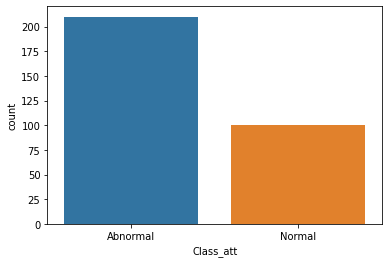

In [5]:
sns.countplot(x = 'Class_att', data=df)

**Enconded Output class**

In [6]:
df['Class_att'] = df['Class_att'].astype('category')
encode_map = {
    'Abnormal': 1,
    'Normal': 0
}

df['Class_att'].replace(encode_map, inplace=True)

In [7]:
g = df.groupby('Class_att')
df = pd.DataFrame(g.apply(lambda x: x.sample(g.size().min()).reset_index(drop=True)))

In [8]:
df['Class_att'].value_counts()

0    100
1    100
Name: Class_att, dtype: int64

In [9]:
df['Class_att']

Class_att    
0          0     0
           1     0
           2     0
           3     0
           4     0
                ..
1          95    1
           96    1
           97    1
           98    1
           99    1
Name: Class_att, Length: 200, dtype: int64

Dataset balanceado!

Create Input and Output Data:

In [10]:
X = df.iloc[:, 0:-1]
y = df.iloc[:, -1]

**Train Test Split**

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=69)

**Padronizar os dados:**
Padronizamos as features pegando a média e dividindo pela variância.

In [12]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

**Parâmetros do modelo**

In [13]:
EPOCHS = 50
BATCH_SIZE = 64
LEARNING_RATE = 0.001

**Definir Dataloaders costumizados**

In [14]:
## train data
class TrainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

## test data    
class TestData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)

In [15]:
train_data = TrainData(torch.FloatTensor(X_train), 
                       torch.FloatTensor(y_train.to_numpy()))
test_data = TestData(torch.FloatTensor(X_test))

**Inicializar os Dataloaders:** para os dados de testes usaremos batch_size = 1.

In [16]:
train_loader = DataLoader(dataset = train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset = test_data, batch_size=1)

**Definir a Arquitetura da Rede**

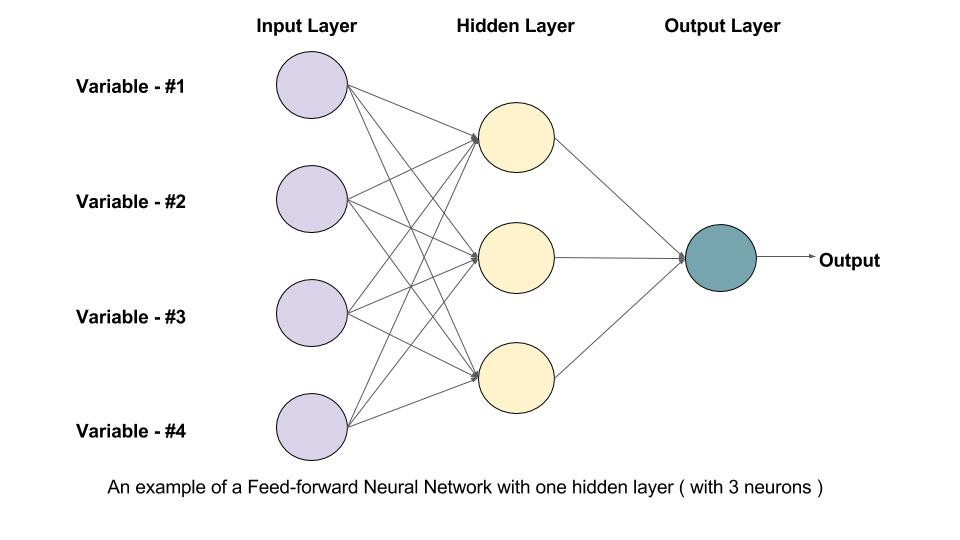

A primeira linha das funções forward() recebe a entrada, passa por nossa primeira camada linear e então aplica a ativação ReLU nela. Em seguida, aplicamos BatchNorm na saída.

Não usamos a função de ativação Sigmoid na camada final durante o treino porque usamos a função de perda nn.BCEWithLogitsLoss() que aplica automaticamente a função de ativação Sigmoid.

In [17]:
class BinaryClassification(nn.Module):
    def __init__(self):
        super(BinaryClassification, self).__init__()
        # Number of input features is 12.
        self.layer_1 = nn.Linear(12, 64) 
        self.layer_2 = nn.Linear(64, 64)
        self.layer_out = nn.Linear(64, 1) 
        
        self.relu = nn.ReLU() # funcao de ativação
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(64)
        self.batchnorm2 = nn.BatchNorm1d(64)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x)) 
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.layer_out(x) 
        
        return x

**Ativar a GPU**

In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


**Inicializar o model, o otimizador e escolher qual função de perda usar**

In [19]:
model = BinaryClassification()
model.to(device)
print(model)
criterion = nn.BCEWithLogitsLoss() 
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

BinaryClassification(
  (layer_1): Linear(in_features=12, out_features=64, bias=True)
  (layer_2): Linear(in_features=64, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


**Treinar o modelo**

Definiremos a função para calcular a precisão.


In [20]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [21]:
model.train()
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
      
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        y_pred = model(X_batch)
        
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        

    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')

Epoch 001: | Loss: 0.73673 | Acc: 43.667
Epoch 002: | Loss: 0.64372 | Acc: 55.000
Epoch 003: | Loss: 0.58686 | Acc: 66.333
Epoch 004: | Loss: 0.60125 | Acc: 67.333
Epoch 005: | Loss: 0.42153 | Acc: 88.000
Epoch 006: | Loss: 0.47410 | Acc: 80.333
Epoch 007: | Loss: 0.51904 | Acc: 75.667
Epoch 008: | Loss: 0.58248 | Acc: 73.000
Epoch 009: | Loss: 0.49126 | Acc: 79.667
Epoch 010: | Loss: 0.36506 | Acc: 91.333
Epoch 011: | Loss: 0.43764 | Acc: 79.667
Epoch 012: | Loss: 0.42804 | Acc: 85.000
Epoch 013: | Loss: 0.46287 | Acc: 74.667
Epoch 014: | Loss: 0.37186 | Acc: 90.667
Epoch 015: | Loss: 0.36037 | Acc: 92.667
Epoch 016: | Loss: 0.34083 | Acc: 87.000
Epoch 017: | Loss: 0.36480 | Acc: 82.000
Epoch 018: | Loss: 0.31215 | Acc: 92.667
Epoch 019: | Loss: 0.31348 | Acc: 87.333
Epoch 020: | Loss: 0.32625 | Acc: 92.333
Epoch 021: | Loss: 0.40319 | Acc: 76.667
Epoch 022: | Loss: 0.26636 | Acc: 92.667
Epoch 023: | Loss: 0.27103 | Acc: 93.333
Epoch 024: | Loss: 0.29150 | Acc: 88.667
Epoch 025: | Los

**Testar o modelo**

In [22]:
y_pred_list = []
model.eval()
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

**Matriz de Confusão**

In [23]:
confusion_matrix(y_test, y_pred_list)

array([[26,  9],
       [ 8, 23]])

**Classificação**

In [24]:
print(classification_report(y_test, y_pred_list))

              precision    recall  f1-score   support

           0       0.76      0.74      0.75        35
           1       0.72      0.74      0.73        31

    accuracy                           0.74        66
   macro avg       0.74      0.74      0.74        66
weighted avg       0.74      0.74      0.74        66

